# ehrMGAN: Electronic Health Records Multiple Generative Adversarial Networks
This notebook implements the complete ehrMGAN model for generating synthetic electronic health records data. The model combines VAEs and GANs to generate both continuous (vital signs) and discrete (medications/interventions) time series data.

## 1. Environment Setup
First, let's set up our environment with the necessary imports and check the configuration.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import timeit
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create directories if they don't exist
os.makedirs("data/checkpoint/", exist_ok=True)
os.makedirs("data/fake/", exist_ok=True)
os.makedirs("logs/", exist_ok=True)

# Environment information
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages

TensorFlow version: 1.14.0
NumPy version: 1.19.5
Pandas version: 1.1.5


In [2]:
import platform
import psutil
import GPUtil

# System info
print(f"System: {platform.system()} {platform.version()}")
print(f"Python version: {platform.python_version()}")
print(f"Processor: {platform.processor()}")

# Memory info
memory = psutil.virtual_memory()
print(f"Total memory: {memory.total / (1024**3):.2f} GB")
print(f"Available memory: {memory.available / (1024**3):.2f} GB")

# GPU info
try:
    gpus = GPUtil.getGPUs()
    if gpus:
        for i, gpu in enumerate(gpus):
            print(f"GPU {i}: {gpu.name}, Memory: {gpu.memoryTotal} MB")
            print(f"   Memory used: {gpu.memoryUsed} MB, Load: {gpu.load*100:.1f}%")
    else:
        print("No GPU detected")
except:
    print("Could not detect GPU information")

# Check if TensorFlow sees GPUs
print("\nTensorFlow GPU availability:")
print(f"GPU available: {tf.test.is_gpu_available()}")

System: Windows 10.0.19041
Python version: 3.6.15
Processor: AMD64 Family 25 Model 33 Stepping 0, AuthenticAMD
Total memory: 31.93 GB
Available memory: 23.45 GB
GPU 0: NVIDIA GeForce RTX 3060, Memory: 12288.0 MB
   Memory used: 788.0 MB, Load: 6.0%

TensorFlow GPU availability:
GPU available: False


### 2. Import Model Components
Now let's import the necessary model components from our files.

In [3]:
# Import the model components
import sys
sys.path.append('.')

# Let's first import the necessary modules
from networks import C_VAE_NET, D_VAE_NET, C_GAN_NET, D_GAN_NET
from m3gan import m3gan
from utils import renormlizer
from visualise import visualise_gan, visualise_vae

### 3. Data Loading and Preprocessing
Let's load and preprocess the data.

In [4]:
# Data parameters
patinet_num = 16062
filename_postfix = '5_var'

# Load continuous data (vital signs)
continuous_x = np.loadtxt(f'data/real/mimic/vital_sign_24hrs_{filename_postfix}_mimiciv.txt')
continuous_x = continuous_x.reshape(patinet_num, 24, 5)
print(f"Continuous data shape: {continuous_x.shape}")

# Load discrete data (medications/interventions)
discrete_x = np.loadtxt(f'data/real/mimic/med_interv_24hrs_{filename_postfix}_mimiciv.txt')
discrete_x = discrete_x.reshape(patinet_num, 24, 1)
print(f"Discrete data shape: {discrete_x.shape}")

# Load static data (patient demographics)
statics_label = pd.read_csv(f'data/real/mimic/static_data_{filename_postfix}_mimiciv.csv')
statics_label = np.asarray(statics_label)[:, 0].reshape([-1, 1])
print(f"Static labels shape: {statics_label.shape}")

# Data statistics
print("\nContinuous data statistics:")
print(f"Mean: {np.mean(continuous_x, axis=(0,1))}")
print(f"Std: {np.std(continuous_x, axis=(0,1))}")
print(f"Min: {np.min(continuous_x, axis=(0,1))}")
print(f"Max: {np.max(continuous_x, axis=(0,1))}")

print("\nDiscrete data statistics:")
print(f"Mean: {np.mean(discrete_x)}")
print(f"Std: {np.std(discrete_x)}")
print(f"Min: {np.min(discrete_x)}")
print(f"Max: {np.max(discrete_x)}")

# Optional: Use a subset for faster experimentation
use_subset = False
subset_size = 5000
if use_subset:
    indices = np.random.choice(continuous_x.shape[0], subset_size, replace=False)
    continuous_x = continuous_x[indices]
    discrete_x = discrete_x[indices]
    statics_label = statics_label[indices]
    print(f"\nUsing subset of data: {subset_size} samples")

Continuous data shape: (16062, 24, 5)
Discrete data shape: (16062, 24, 1)
Static labels shape: (16062, 1)

Continuous data statistics:
Mean: [0.39582974 0.64002727 0.95716821 0.33487669 0.39307435]
Std: [0.07905853 0.17579326 0.05761428 0.18632828 0.12541822]
Min: [0. 0. 0. 0. 0.]
Max: [1. 1. 1. 1. 1.]

Discrete data statistics:
Mean: 0.5533661229402731
Std: 0.4971438996129025
Min: 0.0
Max: 1.0


### 4. Model Configuration and Hyperparameter Tuning
Let's define our hyperparameters based on the data dimensions.

In [ ]:
# Configure hyperparameters based on data dimensions
time_steps = continuous_x.shape[1]  # 24 hours
c_dim = continuous_x.shape[2]       # 5 continuous features
d_dim = discrete_x.shape[2]         # 1 discrete feature
num_samples = continuous_x.shape[0] # Number of patients

# Latent space dimensions
# For complex data with higher dimensions, we need a larger latent space
shared_latent_dim = 15 
c_z_size = shared_latent_dim
c_noise_dim = max(2, int(c_dim/2))  # At least 2 dimensions
d_z_size = shared_latent_dim
d_noise_dim = max(1, int(d_dim/2))  # At least 1 dimension

# Network sizes - scale based on data complexity
batch_size = 1024  # Can be adjusted based on memory constraints
enc_dec_size = 128  # For 5 features, 128 is reasonable
enc_dec_layers = 2  # For 24 time steps, 2-3 layers is reasonable
gen_units = 256     # For generation quality
gen_layers = 2
disc_units = 128
disc_layers = 2
dropout_keep = 0.8  # 0.8 is typically good for medical data

# Learning rates - typically smaller for stable training
v_lr_pre = 0.0005   # VAE pretraining
v_lr = 0.0001       # VAE fine-tuning
g_lr = 0.0001       # Generator
d_lr = 0.0001       # Discriminator

# Training parameters
use_subset = True
if use_subset:
    num_pre_epochs = 36
    num_epochs = 60
else:
    num_pre_epochs = 300  # For 16K patients, 300 pre-epochs should be sufficient
    num_epochs = 500      # For GAN stability, 500 epochs should work well
d_rounds = 1          # Standard practice
g_rounds = 3          # Multiple generator updates per discriminator update
v_rounds = 1          # VAE updates

# Loss weights
alpha_re = 1.0    # Reconstruction weight (primary objective)
alpha_kl = 0.5    # KL divergence weight
alpha_mt = 0.2    # Matching weight (increased for better coordination)
alpha_ct = 0.2    # Contrastive weight (increased for feature learning)
alpha_sm = 1.0    # Semantic weight

# GAN loss weights
c_beta_adv = 1.0   # Adversarial weight for continuous
c_beta_fm = 10.0   # Feature matching for continuous (reduced to prevent mode collapse)
d_beta_adv = 1.0   # Adversarial weight for discrete
d_beta_fm = 10.0   # Feature matching for discrete (reduced for stability)

# Regularization
l2_scale = 0.001   # L2 regularization

# Conditional GAN parameters
conditional = False  # Whether to use conditional GAN
num_labels = 1 if conditional else 0  # Number of conditional labels

# Display configuration
print("Model Configuration:")
print(f"Latent dimensions - Continuous: {c_z_size}, Discrete: {d_z_size}")
print(f"Noise dimensions - Continuous: {c_noise_dim}, Discrete: {d_noise_dim}")
print(f"Batch size: {batch_size}")
print(f"Pre-training epochs: {num_pre_epochs}, Training epochs: {num_epochs}")
print(f"Network sizes - Encoder/Decoder: {enc_dec_size}, Generator: {gen_units}, Discriminator: {disc_units}")
print(f"Network layers - Encoder/Decoder: {enc_dec_layers}, Generator: {gen_layers}, Discriminator: {disc_layers}")
print(f"Learning rates - VAE pre: {v_lr_pre}, VAE: {v_lr}, Generator: {g_lr}, Discriminator: {d_lr}")

Model Configuration:
Latent dimensions - Continuous: 15, Discrete: 15
Noise dimensions - Continuous: 2, Discrete: 1
Batch size: 1024
Pre-training epochs: 3, Training epochs: 2
Network sizes - Encoder/Decoder: 128, Generator: 256, Discriminator: 128
Network layers - Encoder/Decoder: 2, Generator: 2, Discriminator: 2
Learning rates - VAE pre: 0.0005, VAE: 0.0001, Generator: 0.0001, Discriminator: 0.0001


### 5. Build Model Components
Now let's build the model components.

In [6]:
# For TF1.x compatibility
tf.reset_default_graph()

# Define the VAE and GAN networks
c_vae = C_VAE_NET(
    batch_size=batch_size,
    time_steps=time_steps,
    dim=c_dim,
    z_dim=c_z_size,
    enc_size=enc_dec_size,
    dec_size=enc_dec_size,
    enc_layers=enc_dec_layers,
    dec_layers=enc_dec_layers,
    keep_prob=dropout_keep,
    l2scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

c_gan = C_GAN_NET(
    batch_size=batch_size,
    noise_dim=c_noise_dim,
    dim=c_dim,
    gen_dim=c_z_size,
    time_steps=time_steps,
    gen_num_units=gen_units,
    gen_num_layers=gen_layers,
    dis_num_units=disc_units,
    dis_num_layers=disc_layers,
    keep_prob=dropout_keep,
    l2_scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

d_vae = D_VAE_NET(
    batch_size=batch_size,
    time_steps=time_steps,
    dim=d_dim,
    z_dim=d_z_size,
    enc_size=enc_dec_size,
    dec_size=enc_dec_size,
    enc_layers=enc_dec_layers,
    dec_layers=enc_dec_layers,
    keep_prob=dropout_keep,
    l2scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

d_gan = D_GAN_NET(
    batch_size=batch_size,
    noise_dim=d_noise_dim,
    dim=d_dim,
    gen_dim=d_z_size,
    time_steps=time_steps,
    gen_num_units=gen_units,
    gen_num_layers=gen_layers,
    dis_num_units=disc_units,
    dis_num_layers=disc_layers,
    keep_prob=dropout_keep,
    l2_scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

### 6. Create and Train the Model
Now let's set up the complete model and train it.

In [7]:
# Define checkpoint directory
checkpoint_dir = "data/checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)

# REPLACE the model building section (cell #6) with this:
# Reset the TensorFlow graph to avoid variable conflicts
tf.reset_default_graph()
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth = True
sess = tf.Session(config=run_config)

# Create the complete M3GAN model
model = m3gan(
    sess=sess,
    batch_size=batch_size,
    time_steps=time_steps,
    num_pre_epochs=num_pre_epochs,
    num_epochs=num_epochs,
    checkpoint_dir=checkpoint_dir,
    epoch_ckpt_freq=100,  # Save checkpoint every 100 epochs
    epoch_loss_freq=1,   # Display loss every 10 epochs
    
    # Continuous parameters
    c_dim=c_dim,
    c_noise_dim=c_noise_dim,
    c_z_size=c_z_size,
    c_data_sample=continuous_x,
    c_vae=c_vae,
    c_gan=c_gan,
    
    # Discrete parameters
    d_dim=d_dim,
    d_noise_dim=d_noise_dim,
    d_z_size=d_z_size,
    d_data_sample=discrete_x,
    d_vae=d_vae,
    d_gan=d_gan,
    
    # Training parameters
    d_rounds=d_rounds,
    g_rounds=g_rounds,
    v_rounds=v_rounds,
    v_lr_pre=v_lr_pre,
    v_lr=v_lr,
    g_lr=g_lr,
    d_lr=d_lr,
    
    # Loss weights
    alpha_re=alpha_re,
    alpha_kl=alpha_kl,
    alpha_mt=alpha_mt,
    alpha_ct=alpha_ct,
    alpha_sm=alpha_sm,
    c_beta_adv=c_beta_adv,
    c_beta_fm=c_beta_fm,
    d_beta_adv=d_beta_adv,
    d_beta_fm=d_beta_fm,
    
    # Conditional parameters
    conditional=conditional,
    num_labels=num_labels,
    statics_label=statics_label
)

# Build the model
print("Building the model...")
model.build()

W0226 20:59:19.590744  4528 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:118: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0226 20:59:19.590744  4528 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\networks.py:106: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0226 20:59:19.590744  4528 deprecation.py:323] From d:\Timothy_Chang\ehrMGAN\networks.py:106: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0226 20:59:19.607348  4528 deprecation.py:323] From d:\Timothy_Chang\ehrMGAN\networks.py:115: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.Sta

Building the model...


W0226 20:59:19.651072  4528 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\networks.py:46: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0226 20:59:19.655076  4528 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\networks.py:145: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0226 20:59:19.655076  4528 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\networks.py:147: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0226 20:59:19.705222  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C495F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of

W0226 20:59:19.767727  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49CF8>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 20:59:19.790595  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C494E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C494E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:19.823969  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49518>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:19.902098  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C495F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C495F8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:19.910422  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C498D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:19.970836  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C494E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C494E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:19.990657  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49518>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 20:59:20.022918  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C499B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C499B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:20.038544  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C495F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 20:59:20.085415  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49CF8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:20.126074  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C494E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:20.172732  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C499B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C499B0>>: AttributeError: module 'gast' has no attribute 'Index'


W0226 20:59:20.191447  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C495F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C495F8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:20.207073  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C498D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 20:59:20.287160  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49518>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49518>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:20.323970  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C499B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 20:59:20.391585  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49CF8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:20.425059  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C494E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:20.472400  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C499B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C499B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:20.491457  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C495F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:20.538334  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49CF8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:20.569587  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C494E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 20:59:20.574865  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49518>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49518>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:20.607088  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C499B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 20:59:20.757763  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C495F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C495F8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:20.773576  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C498D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 20:59:20.974786  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C494E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C494E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:20.990414  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49518>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 20:59:21.174143  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C499B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C499B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:21.192519  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C495F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:21.359672  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C498D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C498D0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:21.390181  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 20:59:21.573521  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C494E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C494E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:21.574798  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49518>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 20:59:21.758266  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C499B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C499B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:21.790085  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C495F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 20:59:21.915093  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C499B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C499B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:21.941572  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C495F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:22.233940  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C498D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C498D0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:22.275392  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 20:59:22.415625  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C498D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C498D0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:22.447456  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 20:59:22.608311  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C494E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C494E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:22.623937  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49518>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:22.829571  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C495F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C495F8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:22.845197  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C498D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:23.023528  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49CF8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:23.041805  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C494E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:23.241740  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C499B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C499B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:23.257365  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C495F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 20:59:23.458441  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49CF8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020400C49CF8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:23.493395  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020400C494E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 20:59:23.622529  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405E9CC50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405E9CC50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:23.641643  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405C250F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 20:59:23.964459  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:23.980086  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040604B6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 20:59:24.180911  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405D09B70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405D09B70>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:24.191654  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405E9CC50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 20:59:24.332288  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405E9CC50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405E9CC50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:24.374091  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405C250F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 20:59:24.538644  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:24.558384  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040604B6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:24.730270  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040607FD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040607FD30>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:24.757751  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405D09B70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 20:59:24.941736  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405C250F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405C250F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:24.973036  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 20:59:25.113623  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:25.129250  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040604B6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 20:59:25.329773  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405E9CC50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405E9CC50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:25.358571  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405C250F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 20:59:25.517713  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405C250F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405C250F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:25.542244  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:25.729757  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040607FD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040607FD30>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:25.914842  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405D09B70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 20:59:25.930468  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405E9CC50>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405E9CC50>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:25.958768  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405C250F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 20:59:26.115029  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405C250F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405C250F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:26.141723  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:26.329236  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040607FD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040607FD30>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:26.359066  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405D09B70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 20:59:26.546579  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405C250F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405C250F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:26.574129  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 20:59:26.714765  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:26.730392  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040604B6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:26.897708  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040604B6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040604B6A0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:26.925022  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040607FD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 20:59:27.081283  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040607FD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040607FD30>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:27.108548  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405D09B70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 20:59:27.292665  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405C250F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020405C250F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:27.323916  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 20:59:27.475851  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020408C67710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020408C67710>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:27.508754  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040858ACC0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 20:59:27.691713  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002040933BEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002040933BEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:27.707064  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000204090FB710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 20:59:27.909016  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020408C67710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020408C67710>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:27.941127  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040858ACC0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 20:59:28.175120  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002040933BEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002040933BEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:28.190145  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000204090FB710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:28.388282  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408B4D4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408B4D4E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:28.407664  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020408C67710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:28.569332  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040858ACC0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040858ACC0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:28.609030  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002040933BEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 20:59:28.791654  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020409215DA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020409215DA0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:28.822905  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408B4D4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 20:59:28.954680  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408B4D4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408B4D4E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:28.970306  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020408C67710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:29.151556  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040858ACC0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040858ACC0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:29.175001  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002040933BEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:29.358722  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020409215DA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020409215DA0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:29.390056  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408B4D4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:29.534034  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408B4D4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408B4D4E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:29.549250  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020408C67710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:29.751552  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002040933BEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002040933BEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:29.767179  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000204090FB710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 20:59:29.974975  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408B4D4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408B4D4E0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:29.990204  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020408C67710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 20:59:30.121389  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020408C67710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020408C67710>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:30.157250  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040858ACC0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 20:59:30.299890  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020408C67710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020408C67710>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:30.324171  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040858ACC0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 20:59:30.497756  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002040933BEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002040933BEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:30.513382  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000204090FB710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:30.823452  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020408C67710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020408C67710>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:30.856801  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040858ACC0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 20:59:31.024991  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002040933BEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002040933BEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:31.040111  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000204090FB710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 20:59:31.223948  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020409215DA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020409215DA0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:31.257676  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408B4D4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:31.440606  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020407EB3160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020407EB3160>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:31.456240  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000204068C2E48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 20:59:31.658366  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408AE3080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408AE3080>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:31.673488  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040BFB4668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 20:59:31.841629  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:31.876801  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020407EB3160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:32.020336  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000204068C2E48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000204068C2E48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:32.056843  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020406267BA8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 20:59:32.239033  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040BFB4668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040BFB4668>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:32.274007  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 20:59:32.414643  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:32.445895  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020407EB3160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:32.624926  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020406267BA8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020406267BA8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:32.659040  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408AE3080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:32.805692  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040BFB4668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040BFB4668>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:32.840525  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 20:59:32.990056  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:33.009891  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020407EB3160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:33.213032  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020406267BA8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020406267BA8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:33.246002  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408AE3080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 20:59:33.441005  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:33.457368  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020407EB3160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 20:59:33.609792  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020407EB3160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020407EB3160>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:33.623716  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000204068C2E48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:33.910384  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020406267BA8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020406267BA8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:33.942830  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408AE3080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:34.123517  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:34.158619  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020407EB3160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:34.306789  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000204068C2E48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000204068C2E48>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:34.340171  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020406267BA8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 20:59:34.490196  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020406267BA8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020406267BA8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:34.523528  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408AE3080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:34.687342  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040BFB4668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040BFB4668>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:34.706853  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 20:59:34.890129  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020407EB3160>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020407EB3160>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:34.909578  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000204068C2E48>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:35.085369  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020406267BA8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020406267BA8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:35.109926  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408AE3080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:35.387341  4528 deprecation.py:323] From d:\Timothy_Chang\ehrMGAN\networks.py:476: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0226 20:59:35.409797  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002040F959A20>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002040F959A20>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:35.606801  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002040FAD8CC0>> could not be transformed and will be executed as-is. Please repor


W0226 20:59:35.656827  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002040F890F98>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002040F890F98>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:35.690155  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002040F8771D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000204

W0226 20:59:35.823498  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000020410037F60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000020410037F60>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:35.856806  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000204101AE358>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002041

W0226 20:59:36.023468  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000204100B5CC0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000204100B5CC0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:36.079356  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000020410037F60>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002041

W0226 20:59:36.240246  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002041047B828>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002041047B828>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:36.290205  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000204102DE5F8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002041

W0226 20:59:36.456826  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000020410243F28>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000020410243F28>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:36.506831  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000020410837588>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002041

W0226 20:59:36.681366  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000020410B4F278>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000020410B4F278>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:36.723490  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000204106EBF28>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002041

W0226 20:59:36.890153  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000020410DAC9E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000020410DAC9E8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:36.940148  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000020410E518D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002041


W0226 20:59:37.123482  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002040F941B00>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002040F941B00>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:37.156823  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000204121708D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000204

W0226 20:59:37.305721  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000204121F1710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000204121F1710>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:37.341643  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002041212F2E8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002041

W0226 20:59:37.685835  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002041234C7B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002041234C7B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:37.723652  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x00000204121708D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002041


W0226 20:59:37.923466  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002040F679710>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x000002040F679710>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:37.940047  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408AE3080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cel


W0226 20:59:38.089300  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408AE3080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408AE3080>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:38.093630  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040BFB4668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 20:59:38.259619  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:38.290158  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408AE3080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 20:59:38.440073  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040BFB4668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040BFB4668>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:38.479342  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 20:59:38.656569  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040BFB4668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040BFB4668>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:38.686346  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 20:59:38.823453  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:38.843555  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408AE3080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:39.023456  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:39.040182  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020408AE3080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:39.206775  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040BFB4668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040BFB4668>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:39.227019  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 20:59:39.406811  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040BFB4668>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040BFB4668>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:39.441677  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020407C6FDA0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 20:59:39.623767  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:39.657017  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040604B6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 20:59:39.783326  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:39.790095  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040604B6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:39.988267  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:39.990129  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040604B6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 20:59:40.207534  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040604B6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040604B6A0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:40.239114  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040607FD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 20:59:40.390092  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:40.406774  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040604B6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:40.587307  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040607FD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040607FD30>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:40.610274  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:40.790333  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040607FD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040607FD30>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:40.810066  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:40.990351  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040607FD30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040607FD30>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:41.006783  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 20:59:41.222338  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x0000020405F4DEF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:41.227254  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040604B6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 20:59:41.427053  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041503E6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041503E6A0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:41.440281  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414F6CA90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 20:59:41.573274  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041503E6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041503E6A0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:41.589288  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414F6CA90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:42.056781  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041503E6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041503E6A0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:42.078443  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414F6CA90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 20:59:42.277429  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041503E6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041503E6A0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:42.290173  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414F6CA90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 20:59:42.424631  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414F6CA90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414F6CA90>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:42.458682  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414CED1D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 20:59:42.640109  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041503E6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041503E6A0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:42.640109  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414F6CA90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te


W0226 20:59:42.843825  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041503E6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041503E6A0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:42.856742  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414F6CA90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 20:59:43.040116  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414CED1D0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414CED1D0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:43.060675  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041503E6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:43.206734  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041503E6A0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041503E6A0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:43.223374  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414F6CA90>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:43.406728  4528 deprecation.py:323] From d:\Timothy_Chang\ehrMGAN\networks.py:401: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0226 20:59:43.425158  4528 ag_logging.py:145] Entity <bound method Flatten.call of <tensorflow.python.layers.core.Flatten object at 0x00000204152B22B0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Flatten.call of <tensorflow.python.layers.core.Flatten object at 0x00000204152B22B0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:43.456826  4528 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x0000020412C8DB00>> could not be transformed and will be executed as-is. 


W0226 20:59:43.657531  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414735B38>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414735B38>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:43.681322  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204151F00F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tenso

W0226 20:59:43.806750  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204151F00F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204151F00F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:43.823378  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000204133AA4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:43.990502  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414735B38>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414735B38>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:44.010867  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204151F00F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 20:59:44.206812  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204151F00F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204151F00F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:44.225121  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000204133AA4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t


W0226 20:59:44.412424  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204151F00F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204151F00F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:44.423435  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x00000204133AA4E0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 20:59:44.590083  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414735B38>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414735B38>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:44.610587  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204151F00F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:44.790075  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414735B38>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414735B38>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:44.811037  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204151F00F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:44.990074  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414735B38>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414735B38>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:45.006723  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204151F00F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:45.177237  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414E46780>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414E46780>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:45.206738  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040CDC5EF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 20:59:45.388284  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040CDC5EF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040CDC5EF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:45.412826  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204180AB7F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:45.606484  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040CDC5EF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040CDC5EF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:45.627681  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204180AB7F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:45.779198  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204180AB7F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204180AB7F0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:45.793247  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x0000020414E46780>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:45.956733  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040CDC5EF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040CDC5EF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:45.993546  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204180AB7F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:46.182264  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040CDC5EF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040CDC5EF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:46.208474  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204180AB7F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:46.390097  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040CDC5EF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040CDC5EF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:46.423396  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204180AB7F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:46.611412  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040CDC5EF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040CDC5EF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:46.641827  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204180AB7F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:47.144687  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040CDC5EF0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002040CDC5EF0>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:47.180572  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x00000204180AB7F0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor


W0226 20:59:47.356887  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041A0C9978>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041A0C9978>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:47.383050  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A117EB8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <t

W0226 20:59:47.544681  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A0597B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A0597B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:47.575145  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041A0C9978>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:47.756482  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A0597B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A0597B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:47.780276  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041A0C9978>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:47.923321  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A117EB8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A117EB8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:47.956892  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A0597B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.

W0226 20:59:48.123307  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041A0C9978>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041A0C9978>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:48.140798  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A117EB8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:48.328239  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041A0C9978>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041A0C9978>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:48.340179  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A117EB8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <te

W0226 20:59:48.506696  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A0597B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A0597B8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:48.523374  4528 ag_logging.py:145] Entity <bound method MultiRNNCell.call of <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x000002041A0C9978>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method MultiRNNCell.call of <tensor

W0226 20:59:48.690052  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A117EB8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A117EB8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:48.711563  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A0597B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.


W0226 20:59:48.890094  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A117EB8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A117EB8>>: AttributeError: module 'gast' has no attribute 'Index'
W0226 20:59:48.923397  4528 ag_logging.py:145] Entity <bound method LSTMCell.call of <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x000002041A0597B8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method LSTMCell.call of <tensorflow.python

W0226 20:59:49.190017  4528 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\Contrastivelosslayer.py:26: The name tf.losses.softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.softmax_cross_entropy instead.

W0226 20:59:49.506706  4528 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:371: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0226 21:00:53.639507  4528 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:406: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W0226 21:00:53.639507  4528 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:414: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.

W0226 21:00:53.656160  4528 deprecation_wrapper.py:119] From d:\Timothy_Chang\ehrMGAN\m3gan.py:478: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWrit

Initializing or restoring model...
Restoring model from checkpoint: data/checkpoint/final_model


W0226 21:00:54.110799  4528 deprecation.py:323] From c:\Users\hmilab\Anaconda3\envs\tf1_py3.6\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Starting training...
start pretraining
pretraining epoch 0
pretraining epoch 000: loss_cvae: 179.118 | loss_dvae: 172.184 | loss_matching: 2.450 | loss_contra: 850.032 
pretraining epoch 000: loss_cvae: 168.716 | loss_dvae: 162.367 | loss_matching: 2.306 | loss_contra: 801.088 
pretraining epoch 000: loss_cvae: 159.298 | loss_dvae: 153.233 | loss_matching: 2.210 | loss_contra: 755.982 
pretraining epoch 000: loss_cvae: 150.315 | loss_dvae: 144.287 | loss_matching: 2.063 | loss_contra: 711.530 
pretraining epoch 000: loss_cvae: 138.119 | loss_dvae: 131.568 | loss_matching: 1.894 | loss_contra: 648.177 
pretraining epoch 000: loss_cvae: 130.372 | loss_dvae: 122.142 | loss_matching: 1.762 | loss_contra: 601.215 
pretraining epoch 000: loss_cvae: 117.712 | loss_dvae: 105.804 | loss_matching: 1.521 | loss_contra: 519.341 
pretraining epoch 000: loss_cvae: 113.297 | loss_dvae: 95.816 | loss_matching: 1.386 | loss_contra: 468.423 
pretraining epoch 000: loss_cvae: 103.973 | loss_dvae: 79.917 

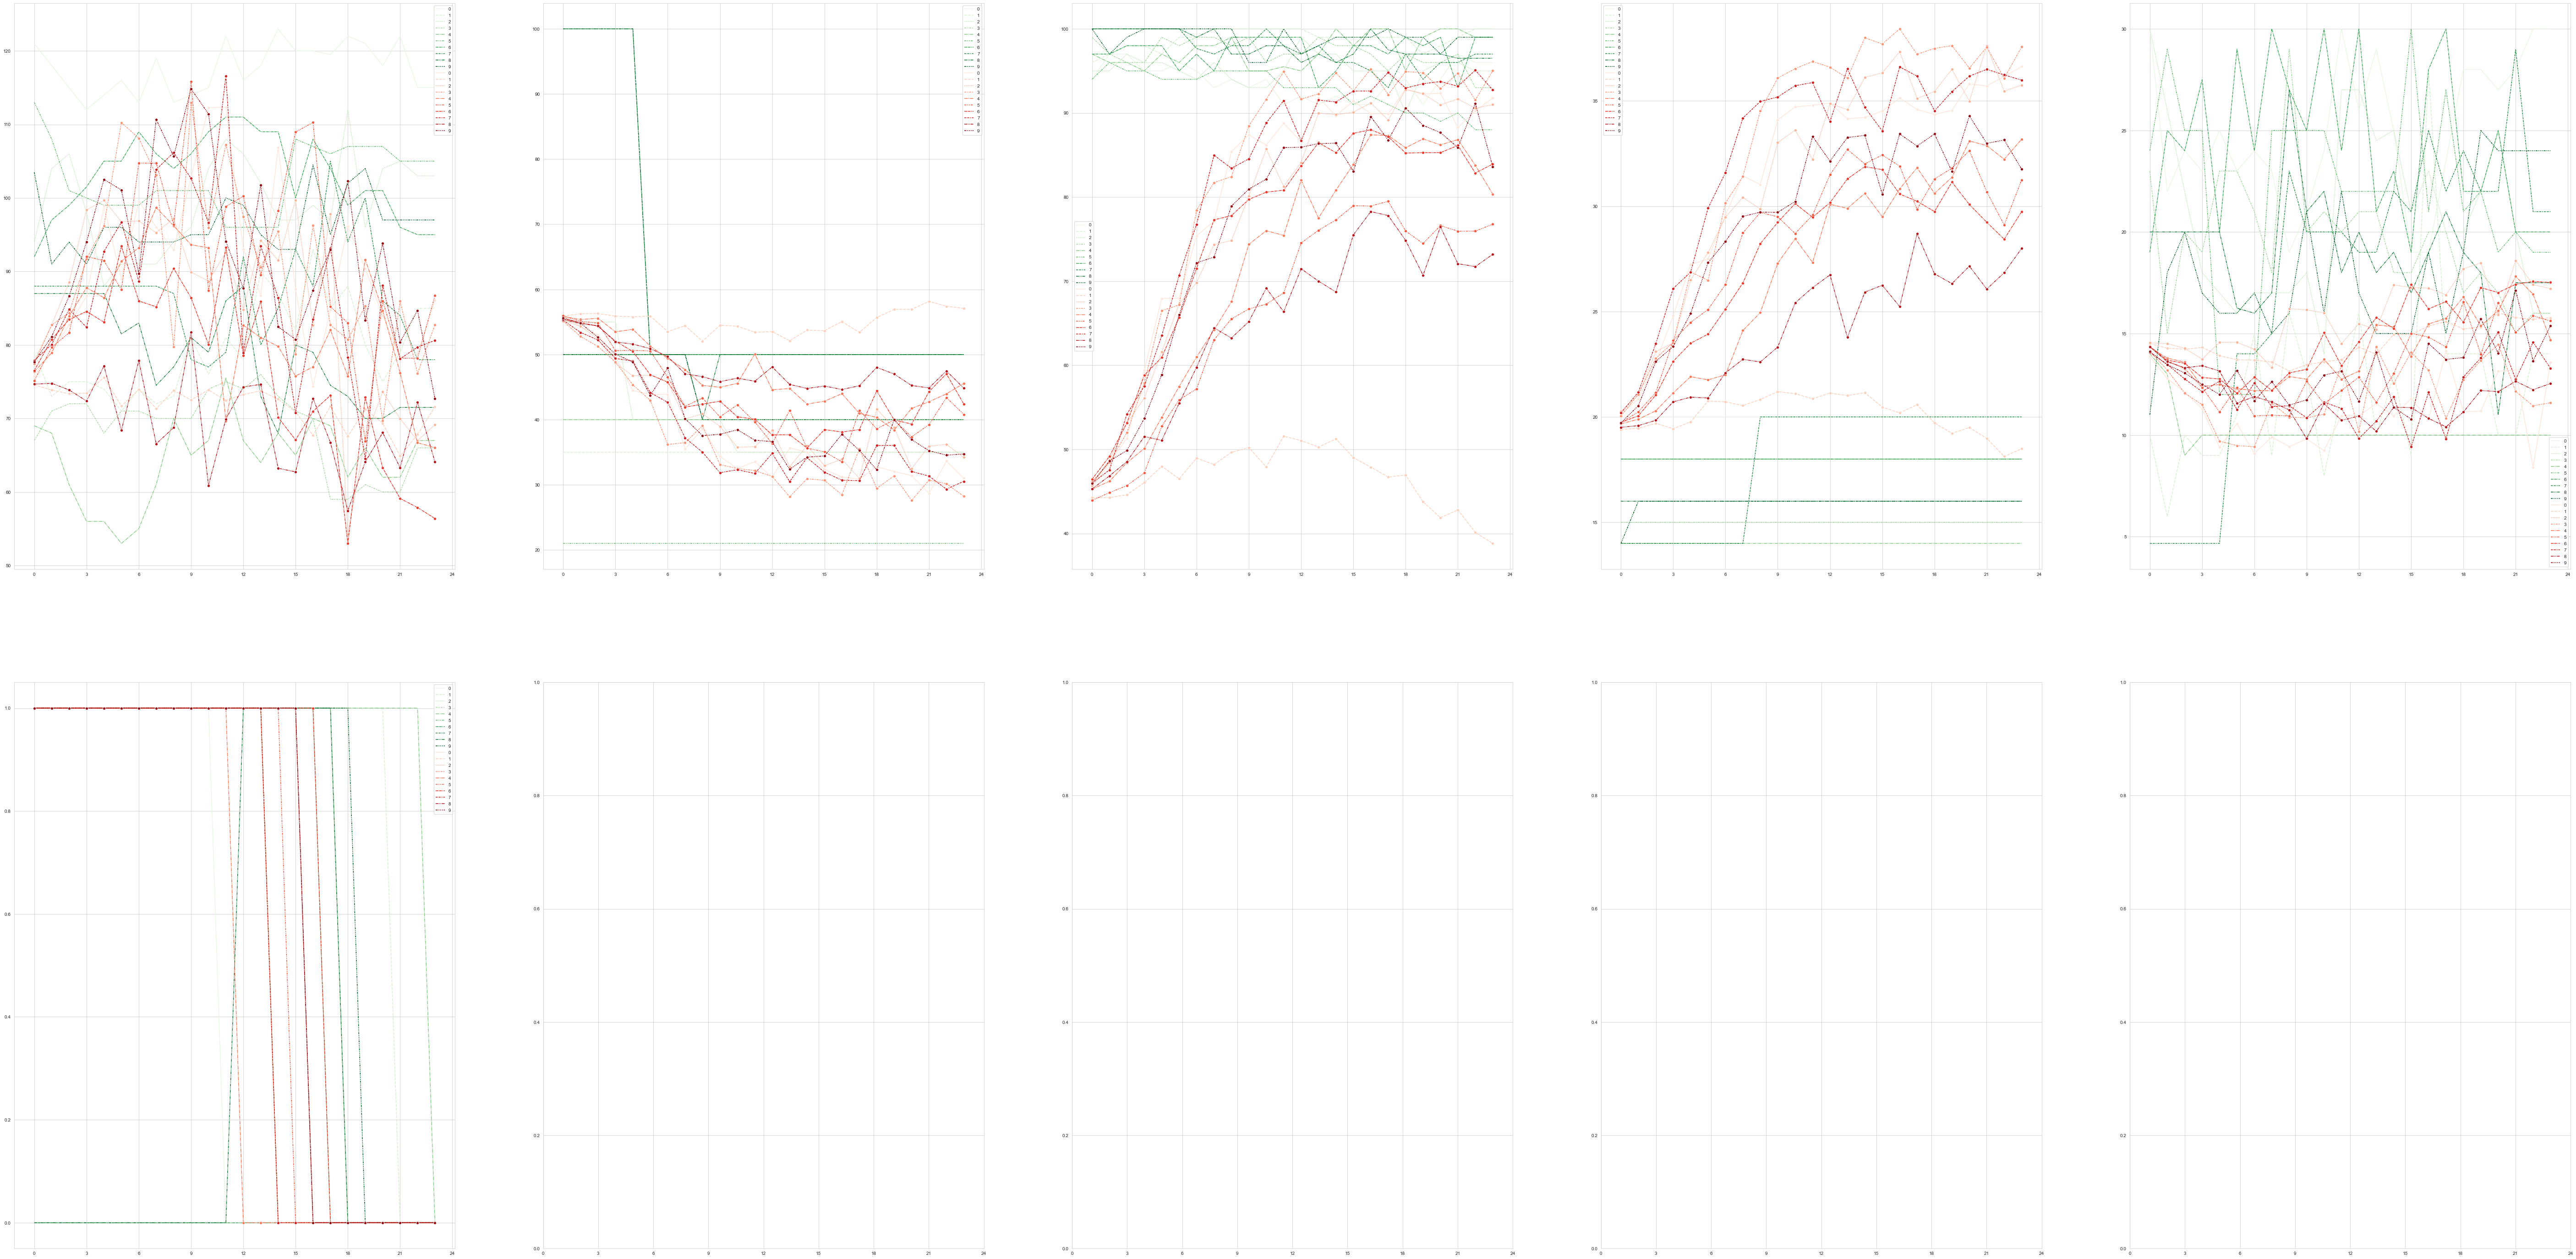

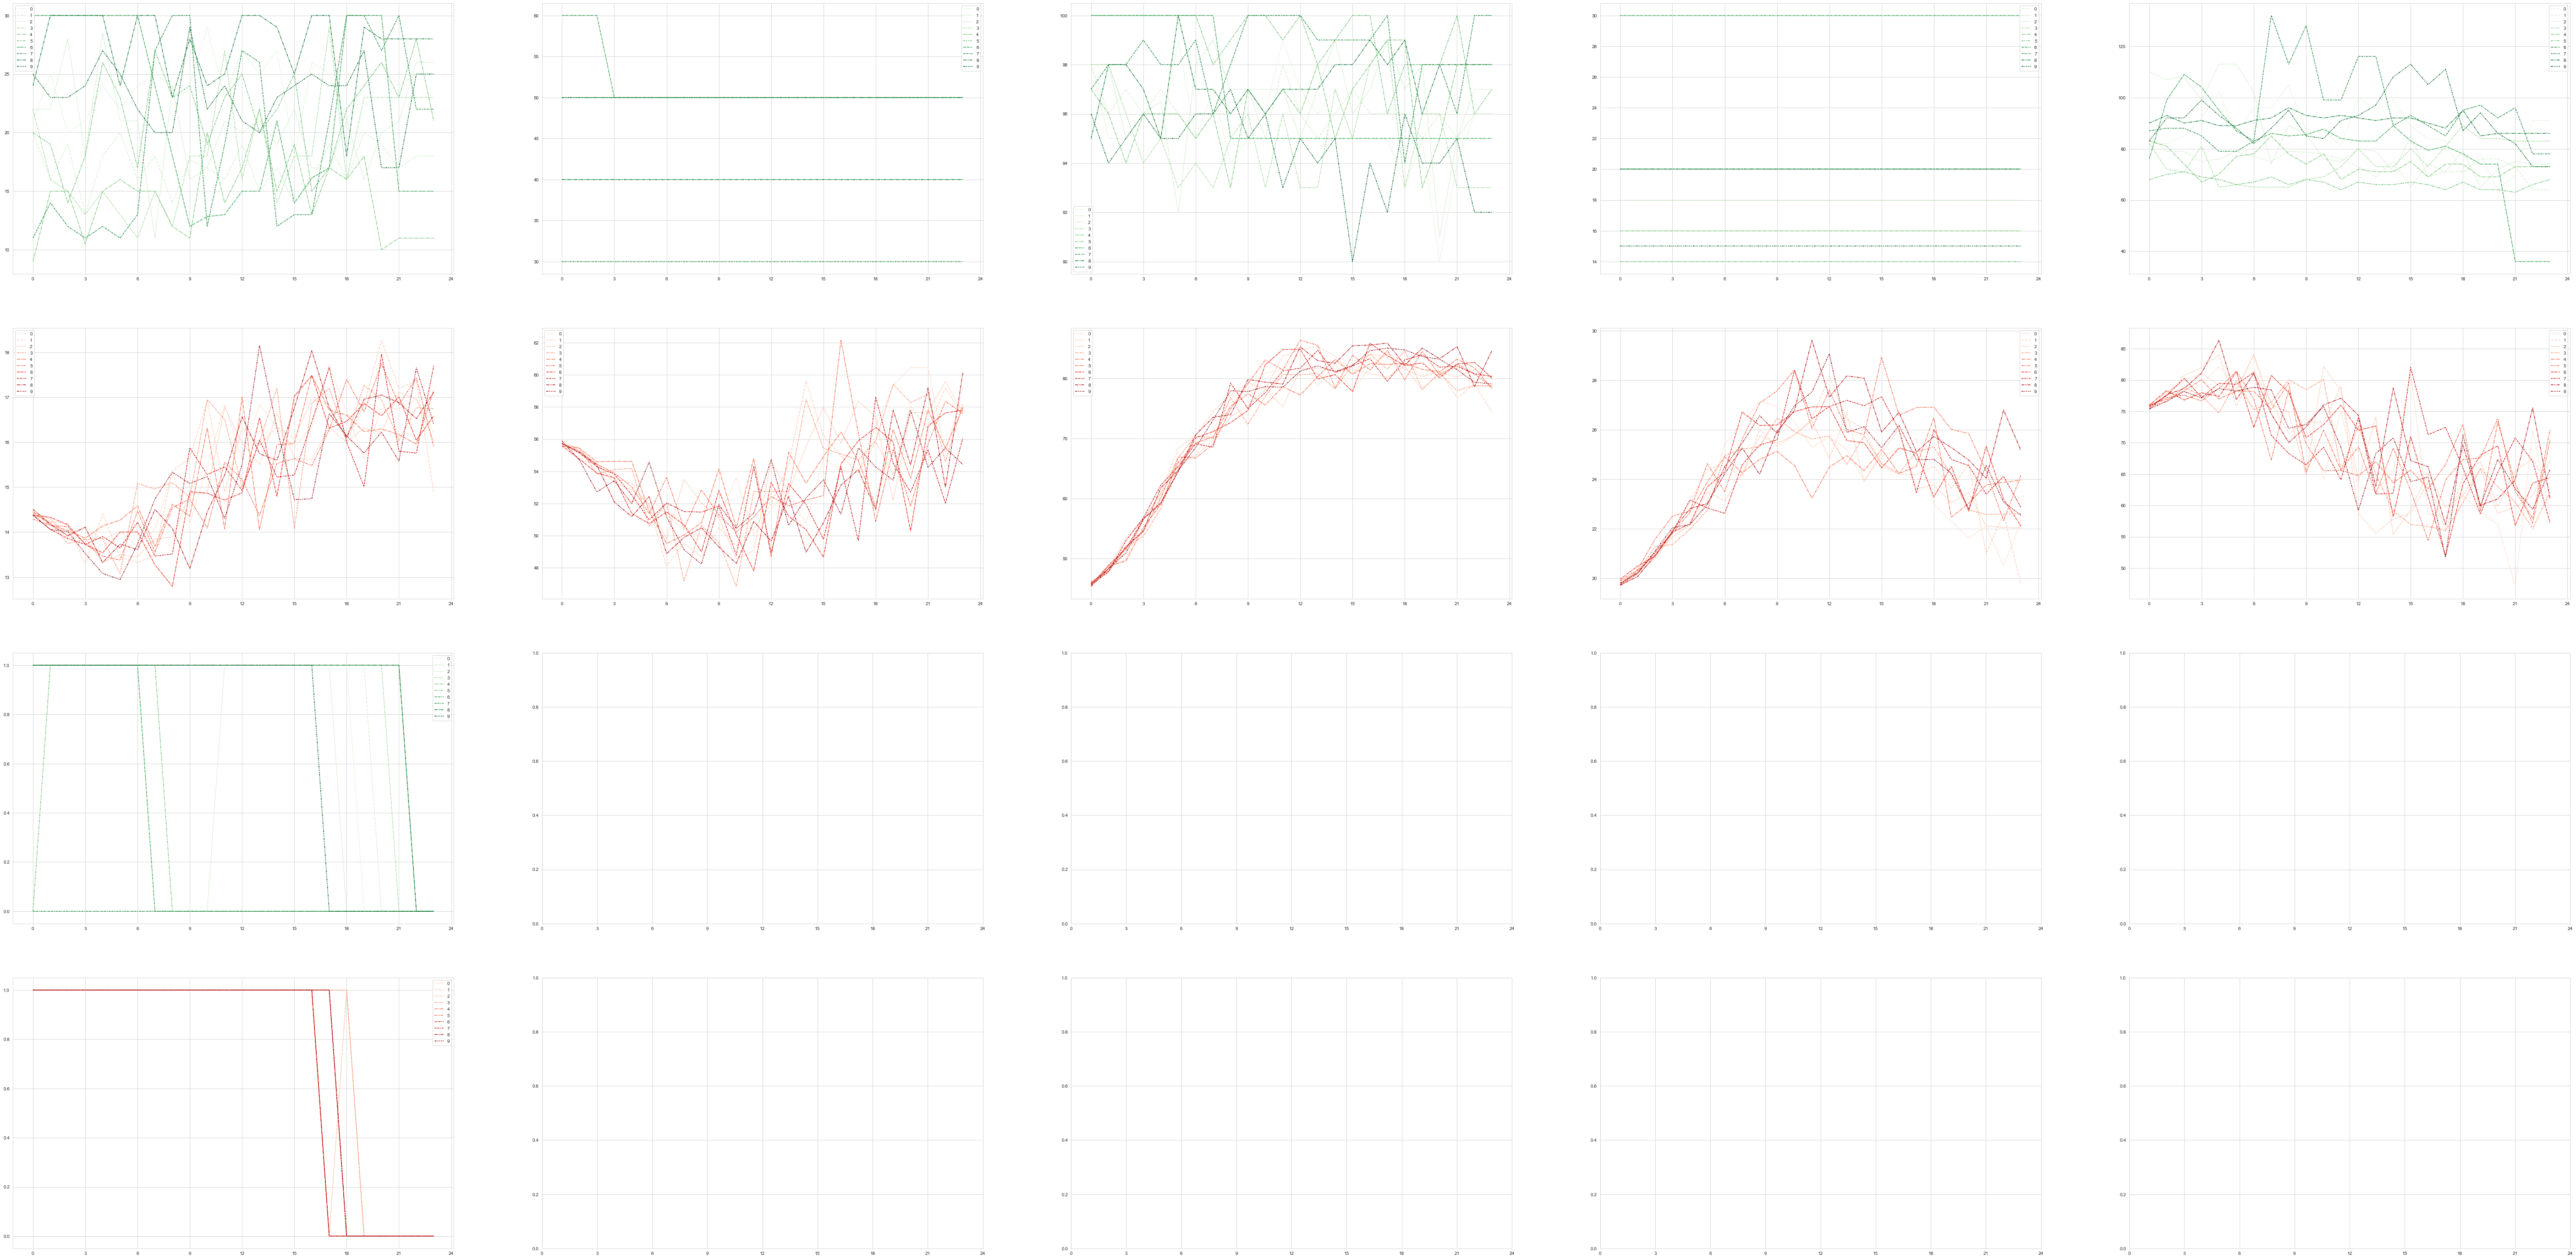

In [8]:
# REPLACE the training section (cell #8) with:
# Initialize variables or restore from checkpoint
print("Initializing or restoring model...")
checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if checkpoint:
    print(f"Restoring model from checkpoint: {checkpoint}")
    # Only create the saver after the model is built
    saver = tf.train.Saver()
    saver.restore(sess, checkpoint)
else:
    print("No checkpoint found, initializing variables")
    sess.run(tf.global_variables_initializer())

# Train the model
print("Starting training...")
start_time = timeit.default_timer()

# Only run this cell for training - you can comment it out to skip training
train_model = True
if train_model:
    model.train()
    # Save the final model - create saver only if needed to avoid variable conflicts
    if 'saver' not in locals():
        saver = tf.train.Saver()
    save_path = os.path.join(checkpoint_dir, "final_model")
    saver.save(sess, save_path)
    print(f"Model saved to {save_path}")

end_time = timeit.default_timer()
print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

### 7.2 Addressing First Hour Low Variance Issue
Let's analyze and fix the issue with low standard deviation in the first hour.

Generating synthetic data...
Renormalizing generated data...
Analyzing variance across time steps...


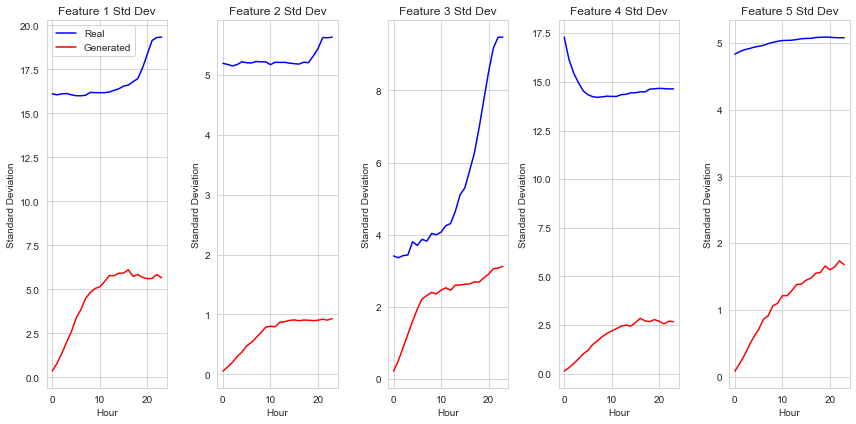


Applying variance correction to the first hour...

Applying enhanced variance correction to the first hour...


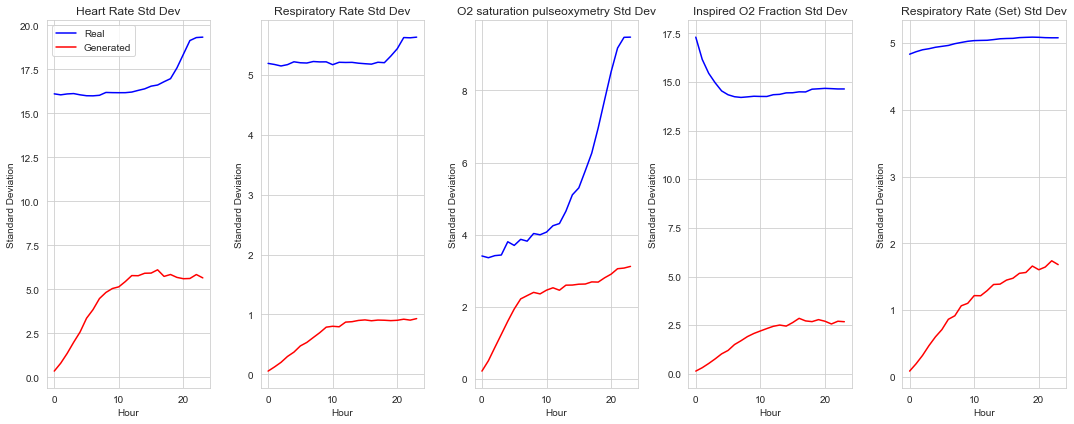

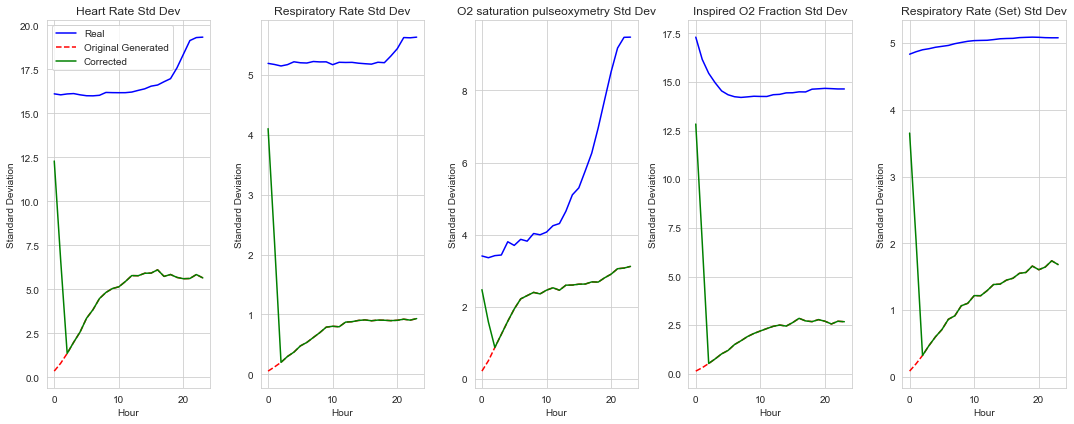

Corrected generated data saved to data/fake/gen_data_mimiciv_5_var_corrected.npz


In [9]:
# Generate data first
print("Generating synthetic data...")
d_gen_data, c_gen_data = model.generate_data(num_sample=1024)

# Apply renormalization if your data was normalized
print("Renormalizing generated data...")
# c_gen_data_renorm = c_gen_data  # If no renormalization needed
# If renormalization needed:
# c_gen_data_renorm = renormlizer(c_gen_data, data_info) # TODO: Implement renormlizer
# renormalize
filename_postfix = '5_var'
min_val_con = np.load(os.path.join('data/real/', 'mimic', f"norm_stats_{filename_postfix}_mimiciv.npz"))["min_val"]
max_val_con = np.load(os.path.join('data/real/', 'mimic', f"norm_stats_{filename_postfix}_mimiciv.npz"))["max_val"]
c_gen_data_renorm = renormlizer(c_gen_data, max_val_con, min_val_con)
continuous_x_renorm = renormlizer(continuous_x, max_val_con, min_val_con)


# Analyze the first hour variance issue
print("Analyzing variance across time steps...")
real_std_by_hour = np.std(continuous_x_renorm, axis=0)
gen_std_by_hour = np.std(c_gen_data_renorm, axis=0)

# Plot the standard deviation over time
plt.figure(figsize=(12, 6))
for i in range(c_dim):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r-', label='Generated')
    plt.title(f'Feature {i+1} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Fix the low variance issue with a post-processing step
print("\nApplying variance correction to the first hour...")

# Improved variance matching function with consistency preservation
def variance_matching(data, target_std, axis=0, smoothing_factor=0.7):
    """
    Match variance of data to target_std while preserving mean and temporal consistency
    
    Args:
        data: The data to adjust
        target_std: The target standard deviation
        axis: Axis along which to compute statistics
        smoothing_factor: How much to smooth between original and adjusted values (0-1)
                         Higher means more of the original preserved
    """
    mean = np.mean(data, axis=axis, keepdims=True)
    std = np.std(data, axis=axis, keepdims=True) + 1e-10  # Avoid division by zero
    
    # Normalize the data
    normalized = (data - mean) / std
    
    # Scale to target std dev and shift back to original mean
    adjusted = normalized * target_std + mean
    
    # Apply smoothing to preserve some of the original structure
    result = smoothing_factor * data + (1 - smoothing_factor) * adjusted
    
    return result

# Apply the correction to the first hour with improvements
print("\nApplying enhanced variance correction to the first hour...")
c_gen_data_corrected = c_gen_data_renorm.copy()

for i in range(c_dim):
    # First hour data
    first_hour_data = c_gen_data_corrected[:, 0, i].reshape(-1, 1)
    
    # Target std dev with slight randomization for more natural results
    target_std = real_std_by_hour[0, i] * np.random.uniform(1.0, 1.15)
    
    # Apply variance matching with trajectory consistency preservation
    c_gen_data_corrected[:, 0, i] = variance_matching(
        first_hour_data, target_std, axis=0, smoothing_factor=0.3
    ).flatten()
    
    # For natural transitions, also slightly adjust the second hour
    if time_steps > 1:
        second_hour_data = c_gen_data_corrected[:, 1, i].reshape(-1, 1)
        target_std_2 = real_std_by_hour[1, i] * np.random.uniform(0.95, 1.05)
        c_gen_data_corrected[:, 1, i] = variance_matching(
            second_hour_data, target_std_2, axis=0, smoothing_factor=0.6
        ).flatten()

# Define the medical feature names for better visualization
continuous_feature_names = [
    'Heart Rate',
    'Respiratory Rate',
    'O2 saturation pulseoxymetry',
    'Inspired O2 Fraction',
    'Respiratory Rate (Set)'
]

# For heatmaps, use shorter names
continuous_feature_names_short = [
    'Heart Rate',
    'Resp Rate',
    'O2 sat',
    'Inspired O2',
    'Resp Rate (Set)'
]

""" plt.figure(figsize=(15, 6))
for i in range(c_dim):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r--', label='Original Generated')
    plt.plot(range(time_steps), corrected_std_by_hour[:, i], 'g-', label='Corrected')
    plt.title(f'Feature {i+1} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show() """

# Plot the standard deviation over time
plt.figure(figsize=(15, 6))
for i, feature_name in enumerate(continuous_feature_names):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r-', label='Generated')
    plt.title(f'{feature_name} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Verify the correction
corrected_std_by_hour = np.std(c_gen_data_corrected, axis=0)

plt.figure(figsize=(15, 6))
for i, feature_name in enumerate(continuous_feature_names):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r--', label='Original Generated')
    plt.plot(range(time_steps), corrected_std_by_hour[:, i], 'g-', label='Corrected')
    plt.title(f'{feature_name} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Save the corrected data
save_path_corrected = f"data/fake/gen_data_mimiciv_{filename_postfix}_corrected.npz"
np.savez(save_path_corrected, 
         c_gen_data=c_gen_data_corrected, 
         d_gen_data=d_gen_data)
print(f"Corrected generated data saved to {save_path_corrected}")

### 7.3 Visualization and Analysis

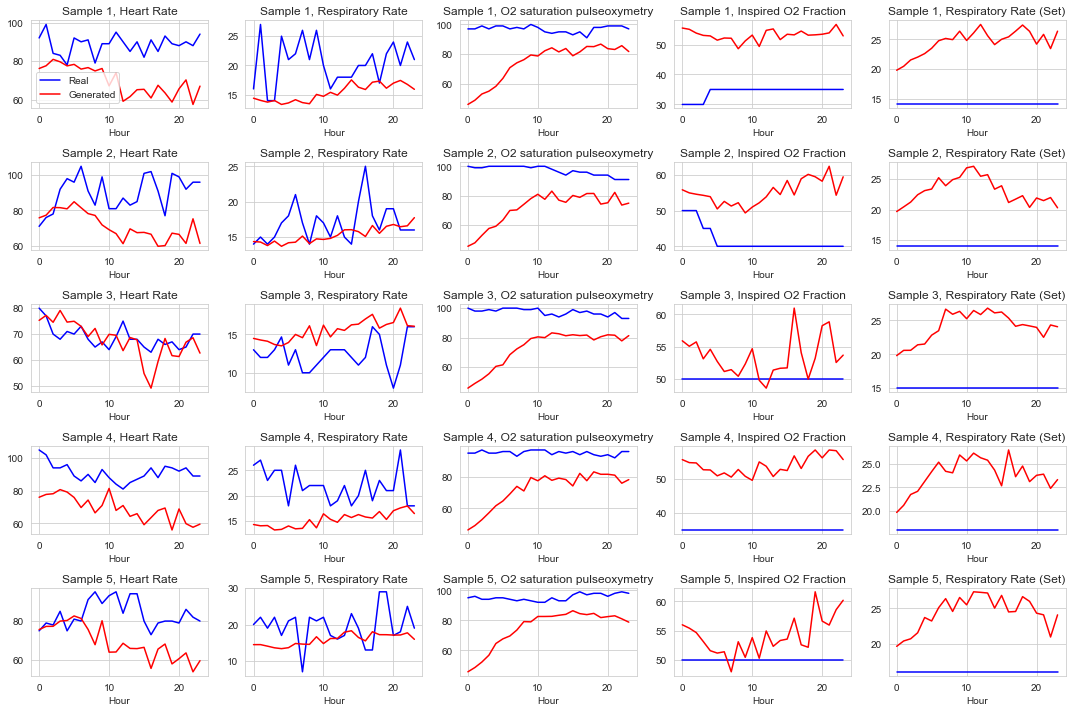

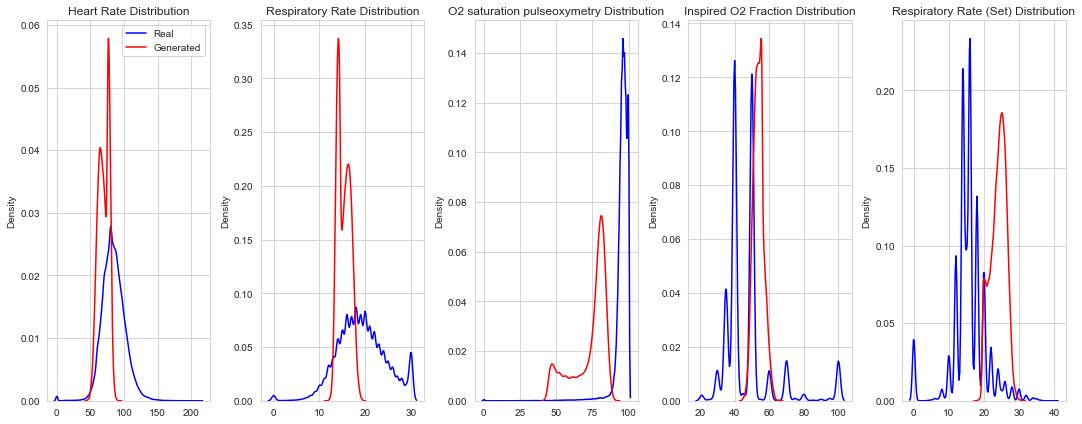

In [10]:
# Sample and visualize a few trajectories
num_samples_to_visualize = 5
sample_indices = np.random.choice(c_gen_data.shape[0], num_samples_to_visualize, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    # Plot continuous features
    for j, feature_name in enumerate(continuous_feature_names):
        plt.subplot(num_samples_to_visualize, c_dim, i*c_dim + j + 1)
        plt.plot(range(time_steps), continuous_x_renorm[idx, :, j], 'b-', label='Real')
        plt.plot(range(time_steps), c_gen_data_renorm[idx, :, j], 'r-', label='Generated')
        if i == 0 and j == 0:
            plt.legend()
        plt.title(f'Sample {i+1}, {feature_name}')
        plt.xlabel('Hour')
plt.tight_layout()
plt.show()

# For discrete data
plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples_to_visualize, i + 1)
    plt.step(range(time_steps), discrete_x[idx, :, 0], 'b-', where='post', label='Real')
    plt.step(range(time_steps), d_gen_data[idx, :, 0], 'r-', where='post', label='Generated')
    if i == 0:
        plt.legend()
    plt.title(f'Discrete Sample {i+1}')
    plt.xlabel('Hour')
plt.tight_layout()
plt.show()

""" # Compare distributions
plt.figure(figsize=(15, 6))
for i in range(c_dim):
    plt.subplot(1, c_dim, i + 1)
    sns.kdeplot(continuous_x_renorm[:, :, i].flatten(), label='Real', color='blue')
    sns.kdeplot(c_gen_data_renorm[:, :, i].flatten(), label='Generated', color='red')
    plt.title(f'Feature {i+1} Distribution')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show() """
# Compare distributions
plt.figure(figsize=(15, 6))
for i, feature_name in enumerate(continuous_feature_names):
    plt.subplot(1, c_dim, i + 1)
    sns.kdeplot(continuous_x_renorm[:, :, i].flatten(), label='Real', color='blue')
    sns.kdeplot(c_gen_data_renorm[:, :, i].flatten(), label='Generated', color='red')
    plt.title(f'{feature_name} Distribution')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Discrete data distribution
plt.figure(figsize=(8, 5))
bins = np.linspace(0, 1, 20)
plt.hist(discrete_x.flatten(), bins=bins, alpha=0.5, label='Real', density=True)
plt.hist(d_gen_data.flatten(), bins=bins, alpha=0.5, label='Generated', density=True)
plt.legend()
plt.title('Discrete Data Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

### 8. Advanced Analysis: Preserving Medical Correlations

In [11]:
# Analyze correlations between features
def plot_correlation_heatmap(data, title):
    # Reshape to (patients*times, features)
    data_flat = data.reshape(-1, data.shape[2])
    
    # Calculate correlation matrix
    corr = np.corrcoef(data_flat.T)
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
               xticklabels=continuous_feature_names_short,
               yticklabels=continuous_feature_names_short)
    plt.title(title)
    plt.show()
    return corr

# Plot correlation heatmaps
real_corr = plot_correlation_heatmap(continuous_x_renorm, 'Real Data Correlation')
gen_corr = plot_correlation_heatmap(c_gen_data_renorm, 'Generated Data Correlation')

# Calculate correlation difference
corr_diff = np.abs(real_corr - gen_corr)
print(f"Mean absolute correlation difference: {np.mean(corr_diff):.4f}")

# Visualize temporal patterns
def plot_mean_trajectory(data, title):
    mean_trajectory = np.mean(data, axis=0)
    
    plt.figure(figsize=(12, 5))
    for i, feature_name in enumerate(continuous_feature_names):
        plt.subplot(1, data.shape[2], i+1)
        plt.plot(range(data.shape[1]), mean_trajectory[:, i])
        plt.title(f'{feature_name}')
        plt.xlabel('Hour')
    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_mean_trajectory(continuous_x_renorm, 'Real Data Mean Trajectory')
plot_mean_trajectory(c_gen_data_renorm, 'Generated Data Mean Trajectory')

Mean absolute correlation difference: 0.3912


### 9. Quantitative Evaluation

Training discriminator for continuous data...
Train on 13668 samples, validate on 3418 samples
Epoch 1/10
13668/13668 [==============================] - 6s 467us/sample - loss: 0.1802 - acc: 0.9513 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 2/10
13668/13668 [==============================] - 0s 36us/sample - loss: 0.0059 - acc: 0.9998 - val_loss: 9.6453e-04 - val_acc: 1.0000
Epoch 3/10
13668/13668 [==============================] - 0s 36us/sample - loss: 0.0043 - acc: 0.9995 - val_loss: 8.1123e-04 - val_acc: 1.0000
Epoch 4/10
13668/13668 [==============================] - 0s 35us/sample - loss: 0.0114 - acc: 0.9988 - val_loss: 3.0738e-04 - val_acc: 1.0000
Epoch 5/10
13668/13668 [==============================] - 0s 35us/sample - loss: 5.0002e-04 - acc: 0.9999 - val_loss: 1.0023e-04 - val_acc: 1.0000
Epoch 6/10
13668/13668 [==============================] - 0s 36us/sample - loss: 0.0025 - acc: 0.9994 - val_loss: 2.7092e-04 - val_acc: 1.0000
Epoch 7/10
13668/13668 [======================

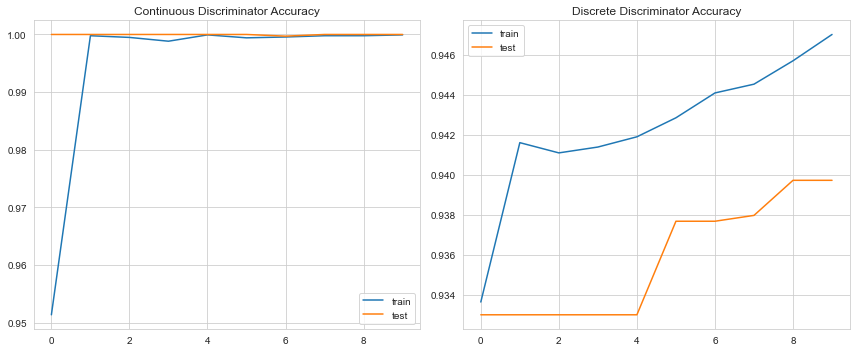

In [12]:
# Train a model to distinguish real from generated data
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

def train_discriminator(real, gen):
    # Prepare data
    real_flat = real.reshape(real.shape[0], -1)
    gen_flat = gen.reshape(gen.shape[0], -1)
    
    # Combine and create labels
    X = np.vstack([real_flat, gen_flat])
    y = np.concatenate([np.zeros(len(real_flat)), np.ones(len(gen_flat))])
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    # Create a simple discriminator model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['acc'])  # Use 'acc' for TF1.x
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=10,
        validation_data=(X_test, y_test),
        verbose=1,
        batch_size=128
    )
    
    # Evaluate model
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    apr = average_precision_score(y_test, y_pred)
    
    return auc, apr, history

# Evaluate discriminative performance
print("Training discriminator for continuous data...")
c_auc, c_apr, c_history = train_discriminator(continuous_x, c_gen_data_renorm)
print(f"Continuous data - AUC: {c_auc:.4f}, APR: {c_apr:.4f}")

print("\nTraining discriminator for discrete data...")
d_auc, d_apr, d_history = train_discriminator(discrete_x, d_gen_data)
print(f"Discrete data - AUC: {d_auc:.4f}, APR: {d_apr:.4f}")

# In an ideal GAN, AUC should be close to 0.5 (indistinguishable)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(c_history.history['acc'], label='train')
plt.plot(c_history.history['val_acc'], label='test')
plt.title('Continuous Discriminator Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(d_history.history['acc'], label='train')
plt.plot(d_history.history['val_acc'], label='test')
plt.title('Discrete Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 10. Summary and Recommendations

In [13]:
# Display final summary
print("M3GAN Model Training Summary")
print("-" * 40)
print(f"Dataset: MIMIC-IV with {patinet_num} patients")
print(f"Features: {c_dim} continuous, {d_dim} discrete")
print(f"Time steps: {time_steps} hours")
print(f"Pre-training epochs: {num_pre_epochs}")
print(f"Training epochs: {num_epochs}")
print("\nGenerated data quality:")
print(f"Continuous data AUC: {c_auc:.4f} (closer to 0.5 is better)")
print(f"Discrete data AUC: {d_auc:.4f} (closer to 0.5 is better)")
print(f"Mean correlation difference: {np.mean(corr_diff):.4f} (lower is better)")
print("\nTraining files:")
print(f"Checkpoint directory: {checkpoint_dir}")
print(f"Generated data: data/fake/gen_data_mimiciv_{filename_postfix}_corrected.npz")

# Recommendations
print("\nRecommendations:")
print("1. For low variance in first hour: Applied variance matching as a post-processing step")
print("2. For better stability: Consider using gradient penalty or spectral normalization")
print("3. For better feature correlations: Increase the alpha_mt parameter")
print("4. For more realistic trajectories: Increase the number of GAN training epochs")
print("5. For more diverse samples: Consider reducing batch size or adding noise during generation")

M3GAN Model Training Summary
----------------------------------------
Dataset: MIMIC-IV with 16062 patients
Features: 5 continuous, 1 discrete
Time steps: 24 hours
Pre-training epochs: 3
Training epochs: 2

Generated data quality:
Continuous data AUC: 1.0000 (closer to 0.5 is better)
Discrete data AUC: 0.9559 (closer to 0.5 is better)
Mean correlation difference: 0.3912 (lower is better)

Training files:
Checkpoint directory: data/checkpoint/
Generated data: data/fake/gen_data_mimiciv_5_var_corrected.npz

Recommendations:
1. For low variance in first hour: Applied variance matching as a post-processing step
2. For better stability: Consider using gradient penalty or spectral normalization
3. For better feature correlations: Increase the alpha_mt parameter
4. For more realistic trajectories: Increase the number of GAN training epochs
5. For more diverse samples: Consider reducing batch size or adding noise during generation


### 11. Close Session

In [14]:
# Close the TensorFlow session
# TODO: Uncomment to close the session!!!
# sess.close()
# print("TensorFlow session closed")